In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fetal-health-classification/fetal_health.csv


In [2]:
!pip install -q imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 100.7 MB/s eta 0:00:0000:01:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
#from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from joblib import Parallel, delayed

import random
import warnings
warnings.filterwarnings("ignore")

2025-07-12 13:41:26.029755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752327686.229507      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752327686.286740      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
df = pd.read_csv('/kaggle/input/fetal-health-classification/fetal_health.csv')
print("Shape:", df.shape)
df.head()

Shape: (2126, 22)


,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [6]:
# Separate features and labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1] - 1  # Adjust labels to [0,1,2]

In [7]:
# 1. Handle missing values (if any)
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

In [8]:
# Balance classes using SMOTE
#smote = SMOTE(random_state=42)
#X_balanced, y_balanced = smote.fit_resample(X, y)

In [9]:
from imblearn.combine import SMOTEENN

# Balance classes using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_balanced, y_balanced = smote_enn.fit_resample(X_imputed, y)


In [10]:
# 3. Apply standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_balanced = scaler.fit_transform(X_balanced)

In [11]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

Training set: (3640, 21)
Test set: (911, 21)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
from joblib import Parallel, delayed
import numpy as np
import random

def improved_cat_hawk_optimizer(objective_function, bounds, num_agents=20, max_iter=30, early_stop_rounds=5, tolerance=1e-4):
    def parallel_objective(positions):
        try:
            results = Parallel(n_jobs=-1, backend='threading')(delayed(objective_function)(pos) for pos in positions)
            return results
        except Exception as e:
            print("🔥 Error during parallel objective evaluation:", e)
            return None

    dim = len(bounds)
    positions = np.random.rand(num_agents, dim)
    for d in range(dim):
        positions[:, d] = positions[:, d] * (bounds[d][1] - bounds[d][0]) + bounds[d][0]

    fitness = parallel_objective(positions)
    if fitness is None:
        print("❌ Initial fitness evaluation failed.")
        return None

    fitness = np.array(fitness)
    best_idx = np.argmin(fitness)
    best_position = positions[best_idx].copy()
    best_fitness = fitness[best_idx]
    fitness_history = [best_fitness]
    no_improvement_rounds = 0

    for t in range(max_iter):
        E = 2 * (1 - t / max_iter)
        for i in range(num_agents):
            r = random.random()
            if r < 0.5:
                new_position = positions[i] + np.random.uniform(-1, 1, dim)
            else:
                if E >= 1:
                    new_position = best_position - np.abs(np.random.rand(dim) * best_position - positions[i])
                else:
                    new_position = best_position - E * np.abs(best_position - positions[i])

            new_position = np.clip(new_position, [b[0] for b in bounds], [b[1] for b in bounds])
            positions[i] = new_position

        fitness = parallel_objective(positions)
        if fitness is None:
            print("❌ Fitness evaluation failed at iteration", t)
            return None

        fitness = np.array(fitness)
        best_idx = np.argmin(fitness)
        current_best = fitness[best_idx]

        if current_best < best_fitness - tolerance:
            best_fitness = current_best
            best_position = positions[best_idx].copy()
            no_improvement_rounds = 0
        else:
            no_improvement_rounds += 1

        fitness_history.append(best_fitness)
        if no_improvement_rounds >= early_stop_rounds:
            print("✅ Early stopping at iteration", t)
            break

    return best_position, best_fitness, fitness_history


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate, LeakyReLU, Activation

def create_fused_activation_model(input_shape, neurons, dropout_rate, num_layers):
    input_layer = Input(shape=input_shape)
    
    x = Dense(neurons, activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    for _ in range(num_layers - 1):
        x = Dense(neurons, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

    # Use a shared base x for branching
    branch_input = x

    # Branch 1 - ReLU
    x1 = Dense(neurons)(branch_input)
    x1 = Activation('relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(dropout_rate)(x1)

    # Branch 2 - LeakyReLU
    x2 = Dense(neurons)(branch_input)
    x2 = LeakyReLU(negative_slope=0.1)(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(dropout_rate)(x2)

    # Branch 3 - Swish
    x3 = Dense(neurons)(branch_input)
    x3 = Activation('swish')(x3)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(dropout_rate)(x3)

    # Merge all
    merged = concatenate([x1, x2, x3])
    output_layer = Dense(3, activation='softmax')(merged)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model


In [15]:
def objective_function(params, X_train, y_train):
    try:
        # Extract hyperparameters
        learning_rate, batch_size, dropout_rate, neurons, num_layers = params[:5]
        batch_size = int(batch_size)
        neurons = int(neurons)
        num_layers = int(num_layers)

        # Binary mask for feature selection
        feature_mask = np.array(params[5:]) > 0.5
        if np.sum(feature_mask) == 0:
            return 1.0  # Penalize solutions selecting 0 features

        # Select only masked features
        X_train_selected = X_train[:, feature_mask]

        # Build the model
        model = create_fused_activation_model(
            input_shape=(X_train_selected.shape[1],),
            neurons=neurons,
            dropout_rate=dropout_rate,
            num_layers=num_layers
        )

        model.compile(
            optimizer=Adam(learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        early_stop = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

        # Train model
        history = model.fit(
            X_train_selected, y_train,
            epochs=10,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=0
        )

        # Return best val_accuracy (negative for minimization)
        val_acc = max(history.history['val_accuracy'])
        return -val_acc

    except Exception as e:
        print("🔥 Error during evaluation:", e)
        return 1.0



In [16]:
from functools import partial
wrapped_objective = partial(objective_function, X_train=X_train, y_train=y_train)

In [17]:
num_features = X_train.shape[1]
hyper_bounds = [
    (0.0001, 0.01),  # learning rate
    (16, 64),        # batch size
    (0.1, 0.5),      # dropout
    (64, 128),       # neurons
    (1, 4)           # layers
]

feature_bounds = [(0, 1)] * num_features  # binary mask
bounds = hyper_bounds + feature_bounds


In [18]:
from functools import partial
wrapped_objective = partial(objective_function, X_train=X_train, y_train=y_train)

best_params, best_fitness, cho_history = improved_cat_hawk_optimizer(wrapped_objective, bounds)
print("Best Hyperparameters:", best_params[:5])
print("Selected Feature Count:", np.sum(np.array(best_params[5:]) > 0.5))
print("Best Val Accuracy:", -best_fitness)

I0000 00:00:1752327700.393798      96 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1752327727.161568     112 service.cc:148] XLA service 0x7ba67400b1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752327727.162085     112 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752327730.287439     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752327737.971691     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
E0000 00:00:1752327748.928302     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752327980.038655     

✅ Early stopping at iteration 8
Best Hyperparameters: [4.05517246e-03 3.88938132e+01 1.00000000e-01 8.20693086e+01
 1.94237335e+00]
Selected Feature Count: 10
Best Val Accuracy: 0.9835164546966553


In [19]:
# Unpack the values
learning_rate, batch_size, dropout_rate, neurons, num_layers = best_params[:5]
feature_mask = best_params[5:]  # remaining params are feature selection mask

# Print hyperparameters
print("🔧 Best Hyperparameters:")
print(f"  Learning Rate   : {learning_rate:.5f}")
print(f"  Batch Size      : {int(batch_size)}")
print(f"  Dropout Rate    : {dropout_rate:.2f}")
print(f"  Neurons         : {int(neurons)}")
print(f"  Num of Layers   : {int(num_layers)}")

# Print feature selection results
selected_features = np.where(np.array(feature_mask) > 0.5)[0]
print("\n🧬 Feature Selection:")
print(f"  Selected Feature Indices : {selected_features.tolist()}")
print(f"  Total Selected Features  : {len(selected_features)} / {len(feature_mask)}")

# Print fitness
print(f"\n📊 Best Validation Accuracy : {-best_fitness:.4f}")


🔧 Best Hyperparameters:
  Learning Rate   : 0.00406
  Batch Size      : 38
  Dropout Rate    : 0.10
  Neurons         : 82
  Num of Layers   : 1

🧬 Feature Selection:
  Selected Feature Indices : [0, 1, 6, 7, 8, 9, 11, 16, 17, 18]
  Total Selected Features  : 10 / 21

📊 Best Validation Accuracy : 0.9835


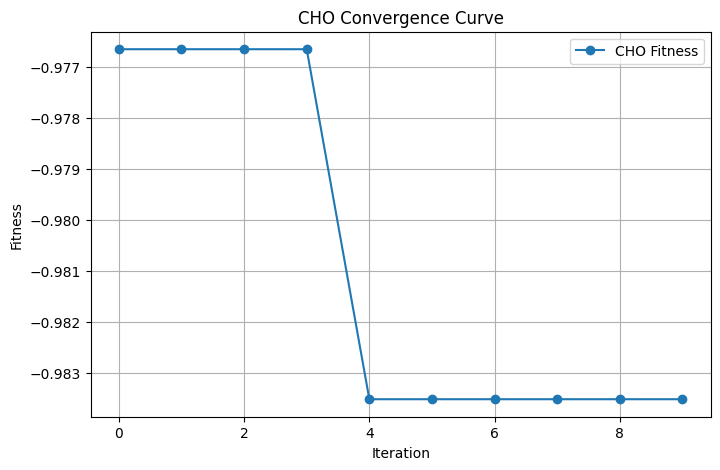

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(cho_history, marker='o', label='CHO Fitness')
plt.title("CHO Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.grid(True)
plt.legend()
plt.show()

In [21]:
# Feature selection mask (values > 0.5 are selected)
feature_mask = np.array(best_params[5:]) > 0.5

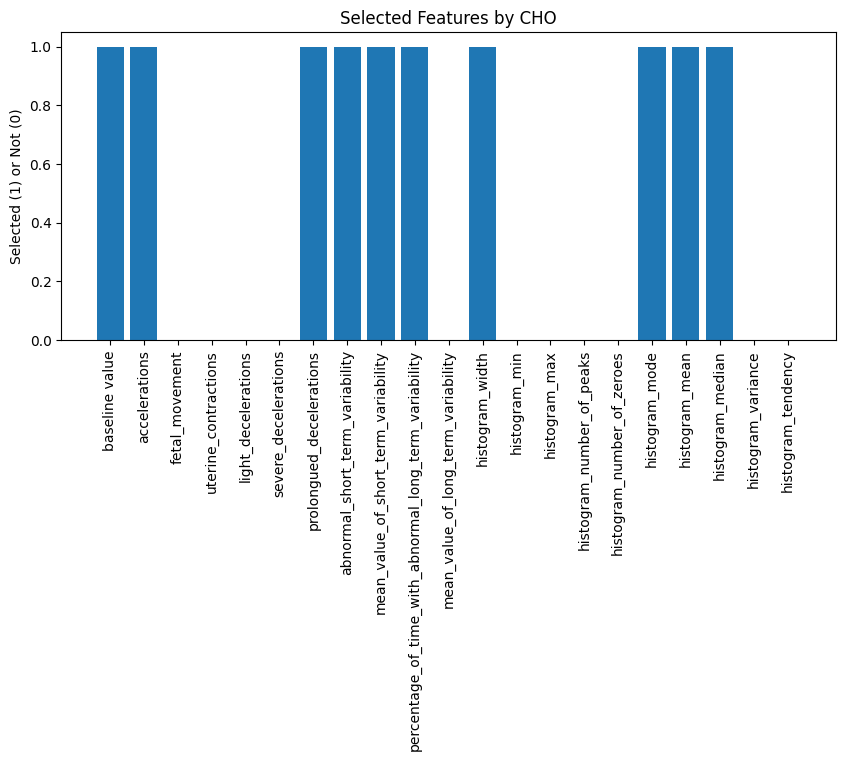

In [22]:
import matplotlib.pyplot as plt

feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]

plt.figure(figsize=(10, 4))
plt.bar(range(len(feature_mask)), feature_mask.astype(int), tick_label=feature_names)
plt.xticks(rotation=90)
plt.ylabel('Selected (1) or Not (0)')
plt.title('Selected Features by CHO')
plt.tight_layout()
plt.show()


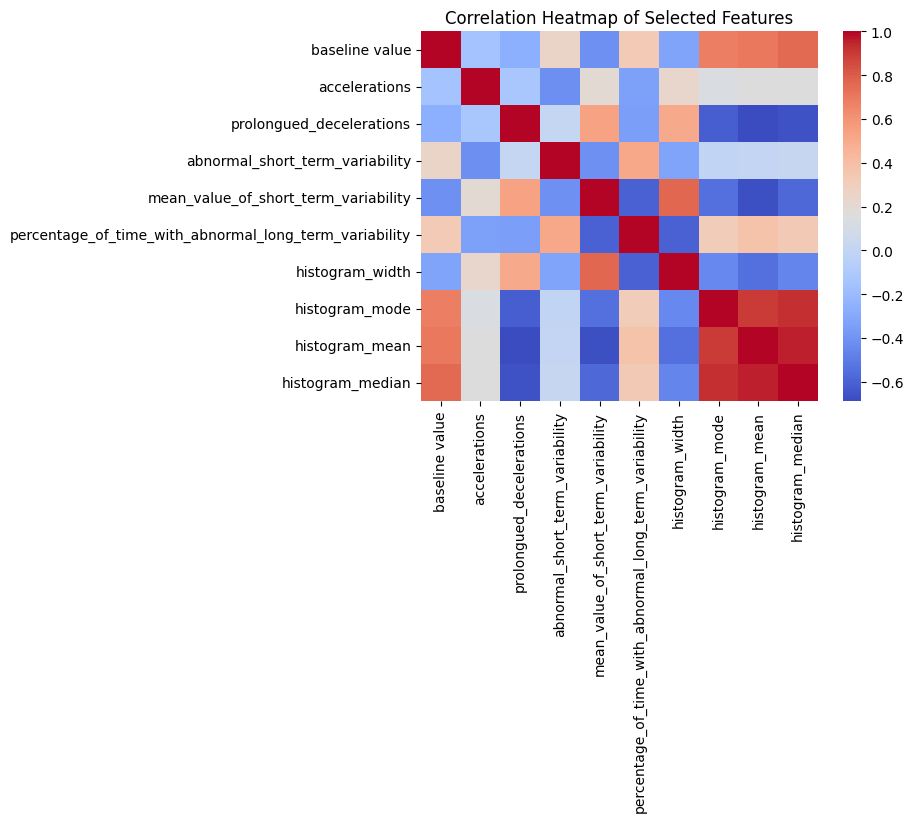

In [23]:
import seaborn as sns

# Apply feature mask
selected_X = X_train[:, feature_mask]

# Convert to DataFrame for heatmap
selected_df = pd.DataFrame(selected_X[:, :20], columns=np.array(feature_names)[feature_mask][:20])  # up to 20 features
sns.heatmap(selected_df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of Selected Features")
plt.show()


In [24]:
print(f"Number of selected features: {np.sum(feature_mask)} out of {len(feature_mask)}")


Number of selected features: 10 out of 21


*✅ Option 1: Rank by CHO Raw Scores (if available)
If your CHO optimizer outputs raw continuous values (not just 0/1) for each feature, you can use them as "importance scores".*

In [25]:
# Extract the feature selection part (after the 5 hyperparams)
feature_scores = np.array(best_params[5:])  # raw scores (e.g., in [0, 1])

# Create DataFrame with feature names and scores
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]
ranking_df = pd.DataFrame({'Feature': feature_names, 'Score': feature_scores})

# Sort by importance
ranking_df = ranking_df.sort_values(by='Score', ascending=False)

# Show top N features
top_n = 20
print(ranking_df.head(top_n))


                                              Feature     Score
11                                    histogram_width  0.801692
1                                       accelerations  0.741385
18                                   histogram_median  0.727418
7                     abnormal_short_term_variability  0.712311
16                                     histogram_mode  0.677287
0                                      baseline value  0.666546
8                mean_value_of_short_term_variability  0.661628
17                                     histogram_mean  0.657929
9   percentage_of_time_with_abnormal_long_term_var...  0.552419
6                            prolongued_decelerations  0.505610
10                mean_value_of_long_term_variability  0.482495
19                                 histogram_variance  0.416596
15                         histogram_number_of_zeroes  0.329052
20                                 histogram_tendency  0.327201
5                                severe_

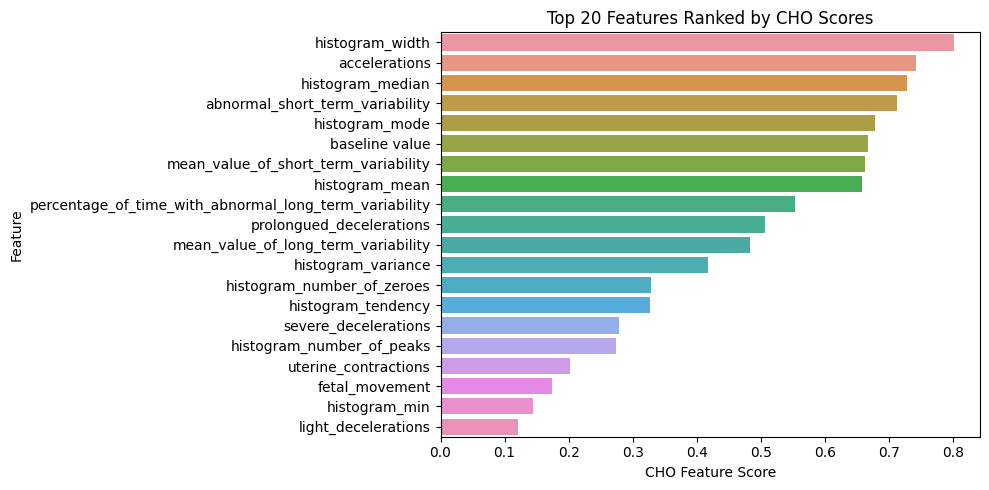

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(x='Score', y='Feature', data=ranking_df.head(top_n))
plt.title(f"Top {top_n} Features Ranked by CHO Scores")
plt.xlabel("CHO Feature Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


                                             Feature  Importance
5  percentage_of_time_with_abnormal_long_term_var...    0.215635
3                    abnormal_short_term_variability    0.142426
8                                     histogram_mean    0.126743
9                                   histogram_median    0.120886
1                                      accelerations    0.093957
4               mean_value_of_short_term_variability    0.079546
2                           prolongued_decelerations    0.065244
7                                     histogram_mode    0.058753
6                                    histogram_width    0.050460
0                                     baseline value    0.046351


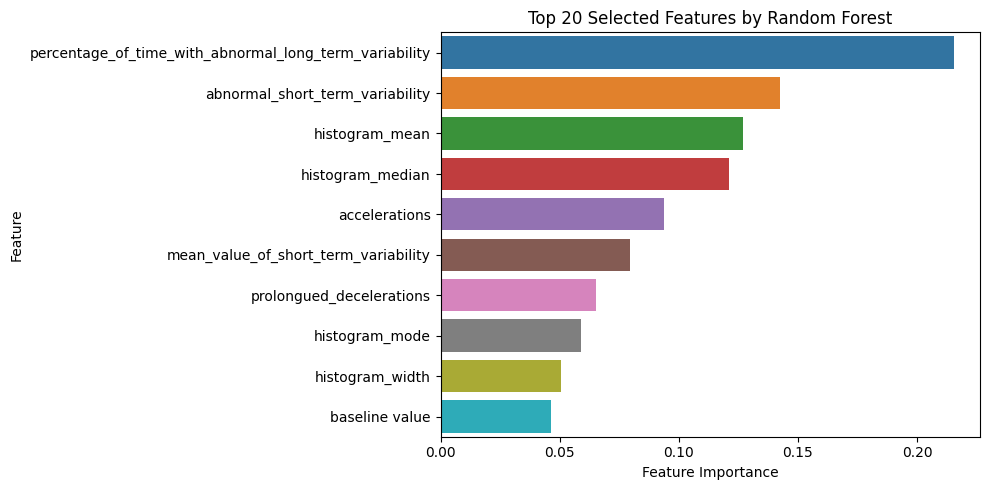

In [27]:
#Rank by Model-Based Importance (Post-Selection)
#If you want to train a model on selected features and let the model determine importances (e.g., using Random Forest):
from sklearn.ensemble import RandomForestClassifier

# Select features using CHO mask
feature_mask = np.array(best_params[5:]) > 0.5
X_selected = X_balanced[:, feature_mask]
y_class = np.argmax(y_balanced, axis=1) if len(y_balanced.shape) > 1 else y_balanced

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_selected, y_class)

# Rank features
selected_names = np.array(feature_names)[feature_mask]
rf_importance_df = pd.DataFrame({
    'Feature': selected_names,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(rf_importance_df.head(top_n))
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df.head(top_n))
plt.title(f"Top {top_n} Selected Features by Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [28]:
from tensorflow import keras

In [29]:
import tensorflow.keras.backend as K

# Define custom metrics
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true)*(1-K.round(y_pred)), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives/(possible_negatives+K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives/(possible_positives+K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives/(possible_positives+K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives/(predicted_positives+K.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

#checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                             #save_best_only=True, mode='max', verbose=1)

#model.fit(X_train, y_train, validation_data=(X_val, y_val),
         # epochs=50, callbacks=[checkpoint])


In [31]:
# Unpack the first 5 elements as hyperparameters
lr, bs, dr, neu, layers = best_params[:5]
bs = int(bs)
neu = int(neu)
layers = int(layers)

# The rest are feature selection indicators
feature_mask = np.array(best_params[5:]) > 0.5  # Select features where flag > 0.5

In [32]:
X_train_selected = X_train[:, feature_mask]
X_test_selected = X_test[:, feature_mask]

In [33]:
# Replace this with your actual model-building function
model = create_fused_activation_model(
    input_shape=(X_train_selected.shape[1],),
    neurons=neu,
    dropout_rate=dr,
    num_layers=layers
)
model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.AUC(name='auc'),
        sensitivity,
        specificity,
        precision,
        recall,
        f1_score
    ]
)


In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy',
    save_best_only=True, mode='max', verbose=1
)

history = model.fit(
    X_train_selected, y_train,
    epochs=50,
    batch_size=bs,
    validation_data=(X_test_selected, y_test),
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8266 - auc: 0.9450 - f1_score: 0.8291 - loss: 0.4481 - precision: 0.8341 - recall: 0.8244 - sensitivity: 0.8244 - specificity: 0.9234
Epoch 1: val_accuracy improved from -inf to 0.91548, saving model to best_model.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.8273 - auc: 0.9453 - f1_score: 0.8298 - loss: 0.4465 - precision: 0.8348 - recall: 0.8251 - sensitivity: 0.8251 - specificity: 0.9236 - val_accuracy: 0.9155 - val_auc: 0.9841 - val_f1_score: 0.9142 - val_loss: 0.2691 - val_precision: 0.9219 - val_recall: 0.9067 - val_sensitivity: 0.9067 - val_specificity: 0.9616
Epoch 2/50
90/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9226 - auc: 0.9885 - f1_score: 0.9231 - loss: 0.2021 - precision: 0.9254 - recall: 0.9210 - sensitivity: 0.9210 - specificity: 0.9629
Epoch 2: val_accuracy improved from 0.91548 to 0.94621, saving model to best_model.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9234 - auc: 

In [35]:
results = model.evaluate(X_test_selected, y_test, verbose=0)
metric_names = model.metrics_names

# Print each metric nicely
print("\n📊 Evaluation Metrics:")
for name, value in zip(metric_names, results):
    print(f"{name}: {value:.4f}")



📊 Evaluation Metrics:
loss: 0.0384
compile_metrics: 0.9879


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict class probabilities and convert to labels
y_pred_probs = model.predict(X_test_selected)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Classification report
print("\n📝 Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

# Confusion matrix
print("\n🧮 Confusion Matrix:")
cm = confusion_matrix(y_true_labels, y_pred_labels)
print(cm)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step 

📝 Classification Report:
              precision    recall  f1-score   support

           0     0.9963    0.9714    0.9837       280
           1     0.9717    0.9936    0.9825       311
           2     0.9969    0.9969    0.9969       320

    accuracy                         0.9879       911
   macro avg     0.9883    0.9873    0.9877       911
weighted avg     0.9881    0.9879    0.9879       911


🧮 Confusion Matrix:
[[272   8   0]
 [  1 309   1]
 [  0   1 319]]


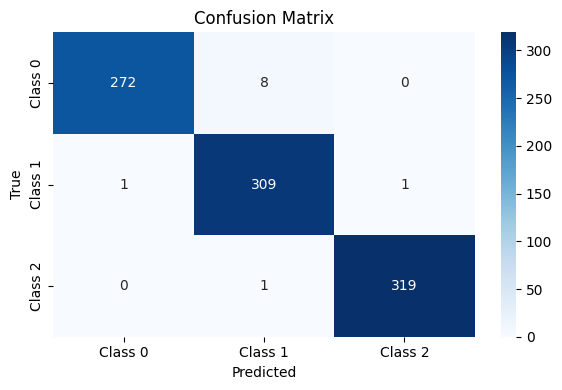

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


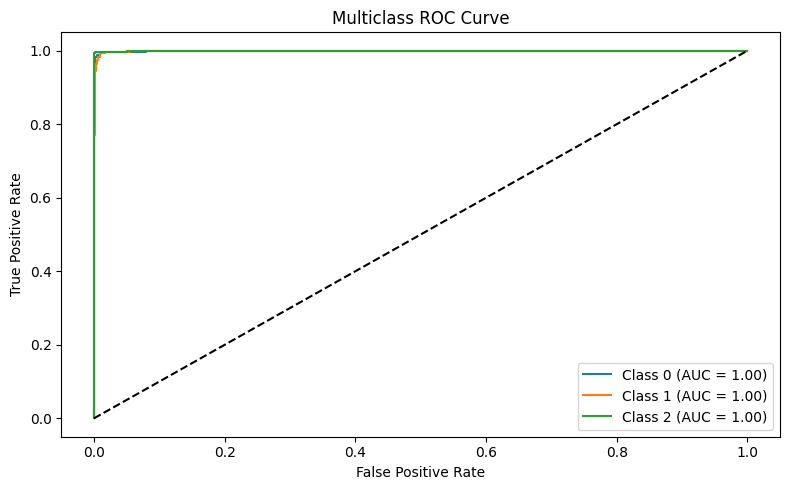

In [38]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# For 3-class ROC AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 5))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


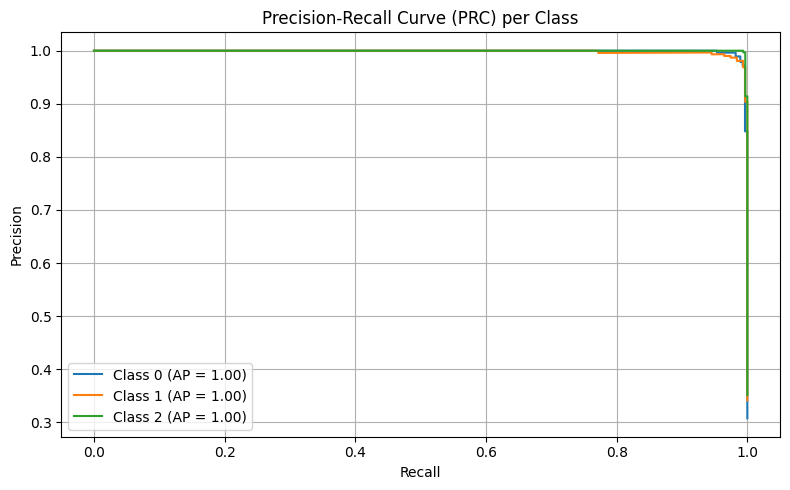

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

n_classes = y_test.shape[1]

precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred_probs[:, i])
plt.figure(figsize=(8, 5))

for i in range(n_classes):
    plt.plot(recall[i], precision[i],
             label=f"Class {i} (AP = {average_precision[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (PRC) per Class")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()


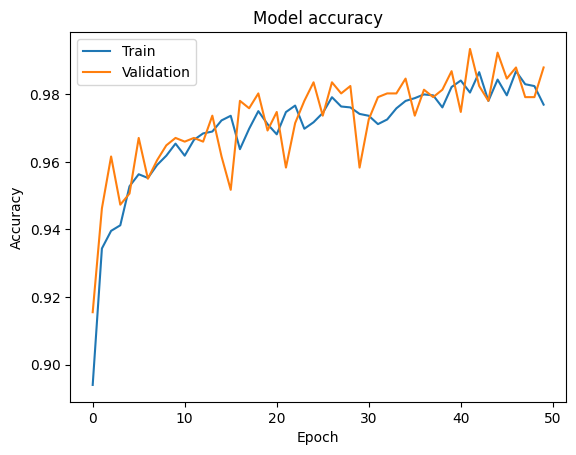

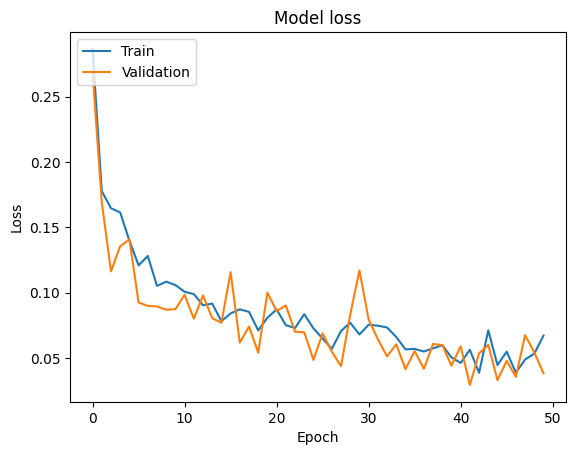

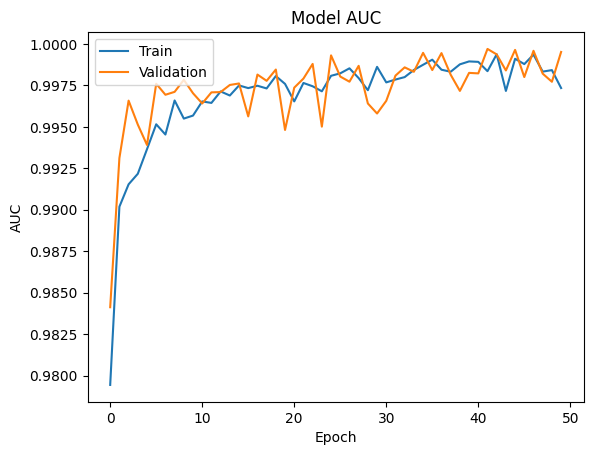

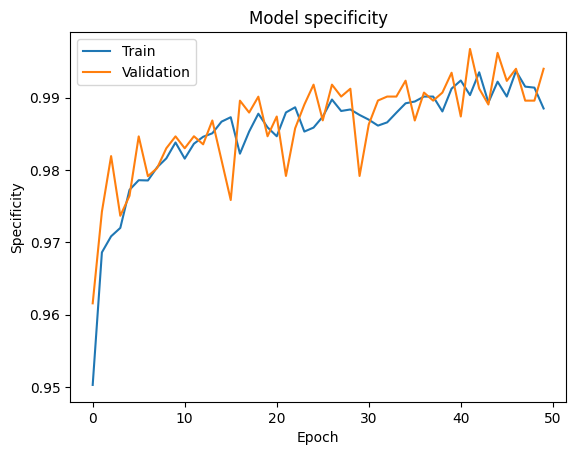

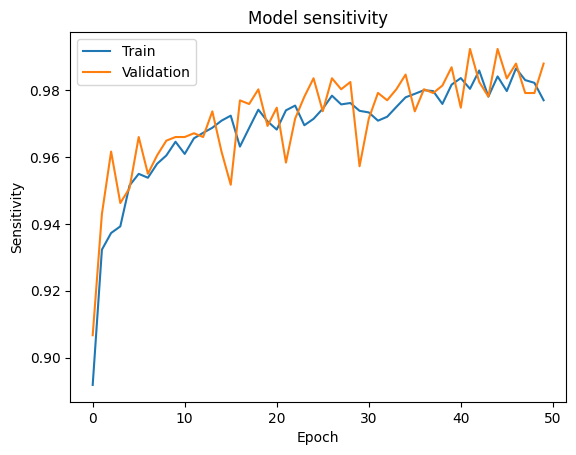

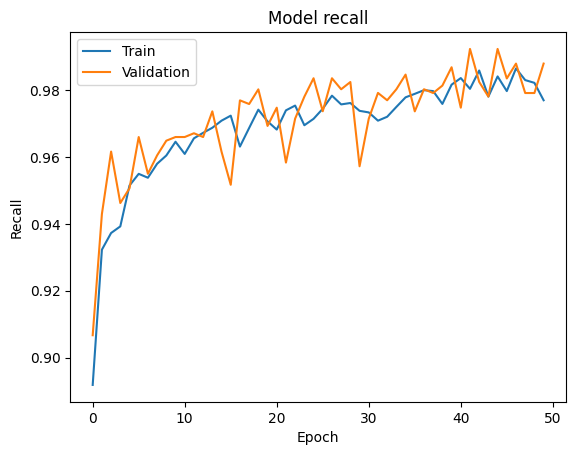

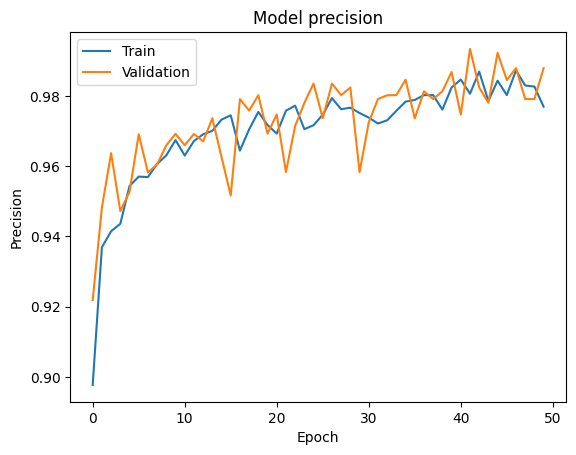

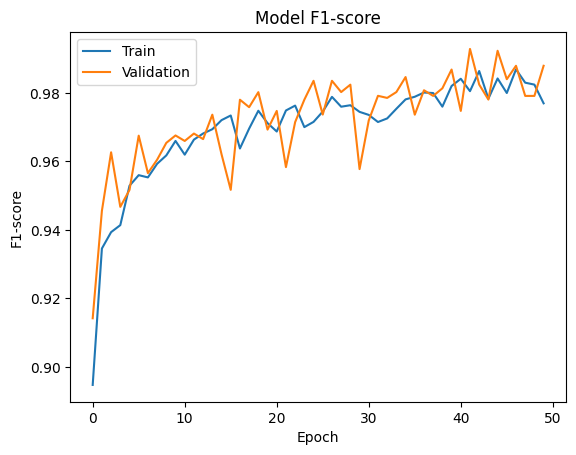

In [40]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot training & validation specificity values
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation specificity values
plt.plot(history.history['specificity'])
plt.plot(history.history['val_specificity'])
plt.title('Model specificity')
plt.ylabel('Specificity')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation sensitivity values
plt.plot(history.history['sensitivity'])
plt.plot(history.history['val_sensitivity'])
plt.title('Model sensitivity')
plt.ylabel('Sensitivity')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation recall values
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation precision values
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation F1-score values
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

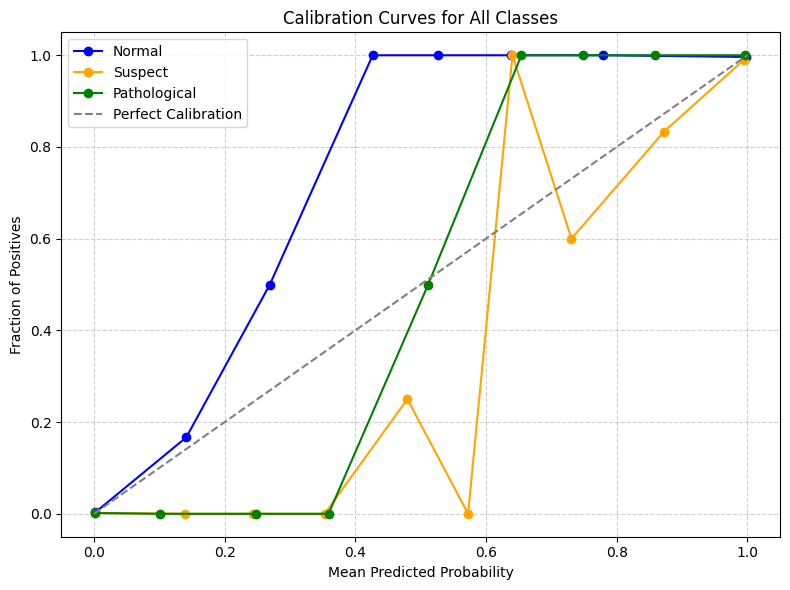

In [41]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Define class names and colors
classes = ['Normal', 'Suspect', 'Pathological']
colors = ['blue', 'orange', 'green']

plt.figure(figsize=(8, 6))

# Plot calibration curve for each class
for i in range(3):
    prob_true, prob_pred = calibration_curve(y_test[:, i], y_pred_probs[:, i], n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=f'{classes[i]}', color=colors[i])

# Reference Line
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')

# Final plot formatting
plt.title('Calibration Curves for All Classes')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [42]:
import numpy as np

# Predicted class indices
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# True class indices
y_true_labels = np.argmax(y_test, axis=1)

# Get misclassified indices
misclassified_idx = np.where(y_true_labels != y_pred_labels)[0]


In [43]:
from collections import Counter
import pandas as pd

# Class names
classes = ['Normal', 'Suspect', 'Pathological']

# Prepare detailed misclassification info
misclassified_info = []

for idx in misclassified_idx:
    true_label = y_true_labels[idx]
    pred_label = y_pred_labels[idx]
    prob = y_pred_probs[idx][pred_label]
    
    misclassified_info.append({
        'Index': idx,
        'True Class': classes[true_label],
        'Predicted Class': classes[pred_label],
        'Predicted Probability': round(prob, 4)
    })

# Convert to DataFrame
misclassified_df = pd.DataFrame(misclassified_info)
print("🔍 Misclassified Samples (first 10 shown):")
print(misclassified_df.head(10))


🔍 Misclassified Samples (first 10 shown):
   Index    True Class Predicted Class  Predicted Probability
0      4       Suspect    Pathological                 0.5124
1    138       Suspect          Normal                 0.9138
2    154        Normal         Suspect                 0.8757
3    199        Normal         Suspect                 0.5947
4    237        Normal         Suspect                 0.9200
5    284        Normal         Suspect                 0.7405
6    370        Normal         Suspect                 0.5772
7    437        Normal         Suspect                 0.5458
8    576  Pathological         Suspect                 0.9588
9    618        Normal         Suspect                 0.7339


In [44]:
error_counts = misclassified_df['True Class'].value_counts()
print("\n❌ Misclassification Count per True Class:")
print(error_counts)

# Confusion between class pairs
confusion_pairs = misclassified_df.groupby(['True Class', 'Predicted Class']).size().unstack().fillna(0)
print("\n🔁 Confusion Matrix Between Classes:")
print(confusion_pairs)


❌ Misclassification Count per True Class:
True Class
Normal          8
Suspect         2
Pathological    1
Name: count, dtype: int64

🔁 Confusion Matrix Between Classes:
Predicted Class  Normal  Pathological  Suspect
True Class                                    
Normal              0.0           0.0      8.0
Pathological        0.0           0.0      1.0
Suspect             1.0           1.0      0.0


In [45]:
# Show the features of first 5 misclassified examples
print("\n📌 First 5 Misclassified Feature Rows:")
print(pd.DataFrame(X_test_selected[misclassified_idx[:5]]))


📌 First 5 Misclassified Feature Rows:
          0         1         2         3         4         5         6  \
0  0.599766 -0.523892 -0.490803  0.867000 -0.842766  1.864243  0.252863   
1 -0.042577  0.383569  0.818963 -1.457751  0.790808 -0.606107  1.101426   
2  0.801302 -0.523892 -0.490803 -0.347088 -0.436254 -0.383328  1.121365   
3  0.801302 -0.523892 -0.490803  0.684887 -0.944394 -0.538332 -0.935614   
4  0.599766 -0.187744 -0.490803  0.502773 -0.741138 -0.693337 -0.981325   

          7         8         9  
0  0.498198  0.546563  0.505550  
1  0.439976 -0.220327  0.071299  
2  0.542136  0.781089  0.722007  
3  0.498198  0.640373  0.559664  
4  0.761825  0.781089  0.776122  


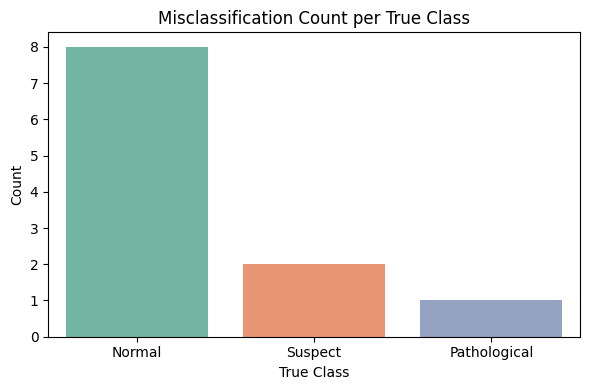

In [46]:
# Count misclassifications per true class
error_counts = misclassified_df['True Class'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=error_counts.index, y=error_counts.values, palette='Set2')
plt.title('Misclassification Count per True Class')
plt.ylabel('Count')
plt.xlabel('True Class')
plt.tight_layout()
plt.show()


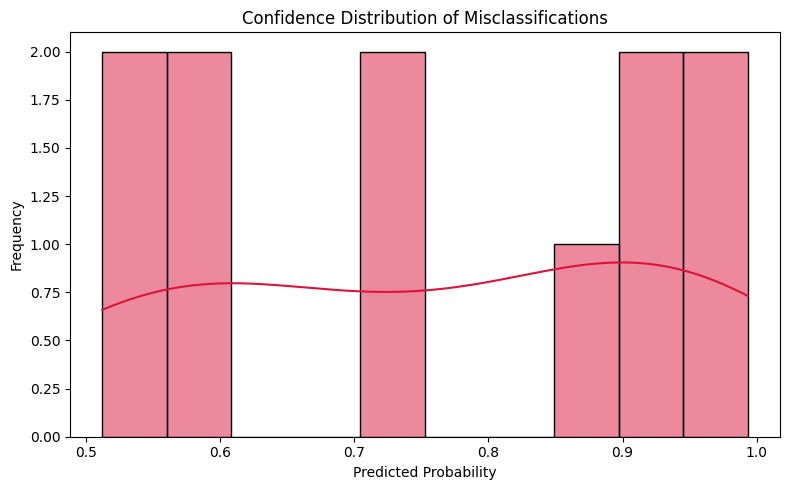

In [47]:
plt.figure(figsize=(8, 5))
sns.histplot(misclassified_df['Predicted Probability'], bins=10, kde=True, color='crimson')
plt.title('Confidence Distribution of Misclassifications')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


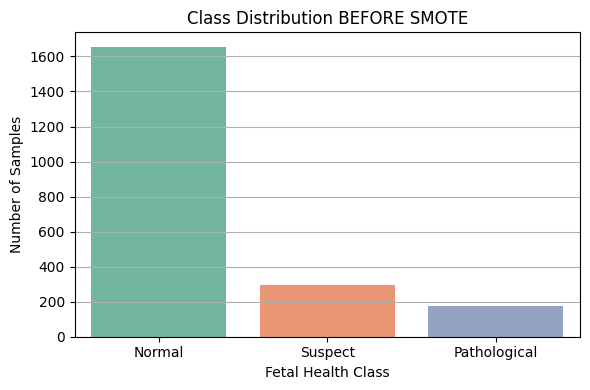

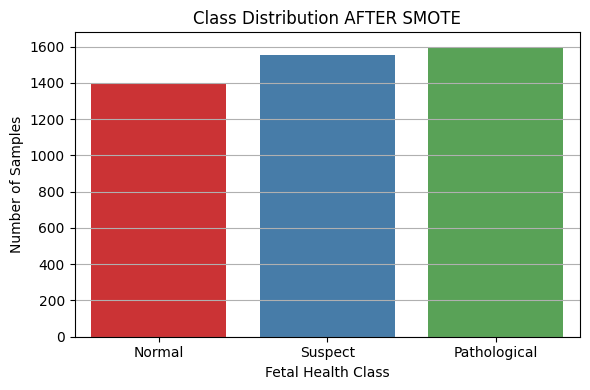

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Original labels before SMOTE
y_original = df['fetal_health']  # Replace 'df' with your original DataFrame variable if different

plt.figure(figsize=(6,4))
sns.countplot(x=y_original, palette="Set2")
plt.title("Class Distribution BEFORE SMOTE")
plt.xlabel("Fetal Health Class")
plt.ylabel("Number of Samples")
plt.xticks([0,1,2], ['Normal', 'Suspect', 'Pathological'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Labels after SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_balanced, palette="Set1")
plt.title("Class Distribution AFTER SMOTE")
plt.xlabel("Fetal Health Class")
plt.ylabel("Number of Samples")
plt.xticks([0,1,2], ['Normal', 'Suspect', 'Pathological'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [49]:
df_compare = pd.DataFrame({
    'Before SMOTE': y_original.value_counts().sort_index(),
    'After SMOTE': pd.Series(y_balanced).value_counts().sort_index()
}, index=[0, 1, 2])  # Use numeric indices matching the classes

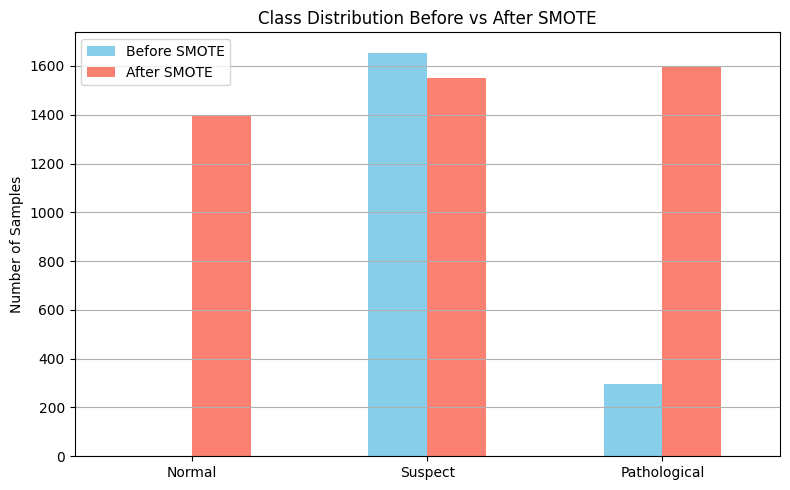

In [50]:
ax = df_compare.plot(kind='bar', figsize=(8,5), color=['skyblue', 'salmon'])
ax.set_xticklabels(['Normal', 'Suspect', 'Pathological'], rotation=0)
plt.title("Class Distribution Before vs After SMOTE")
plt.ylabel("Number of Samples")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Visualize Feature Embeddings Using t-SNE or PCA**
You can extract the activations (features) from the last hidden layer for your test set, then apply t-SNE or PCA to visualize the feature space in 2D or 3D.

In [51]:
from tensorflow.keras.models import Model

# Use trained model and extract output from the penultimate layer
embedding_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Get embeddings from selected test set
embeddings = embedding_model.predict(X_test_selected)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step 


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


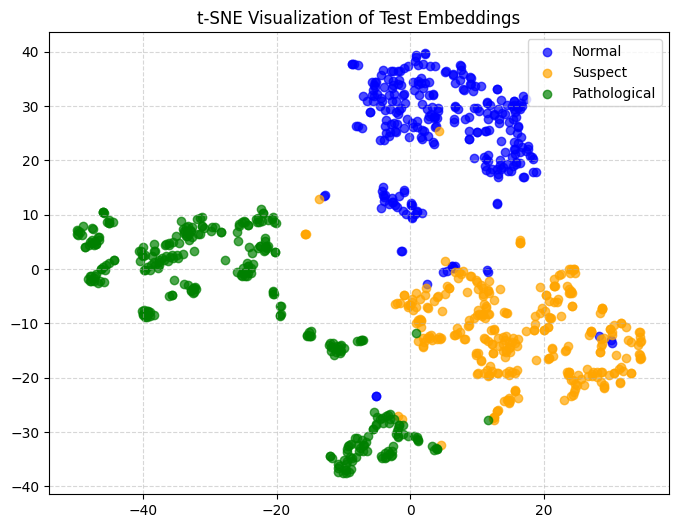

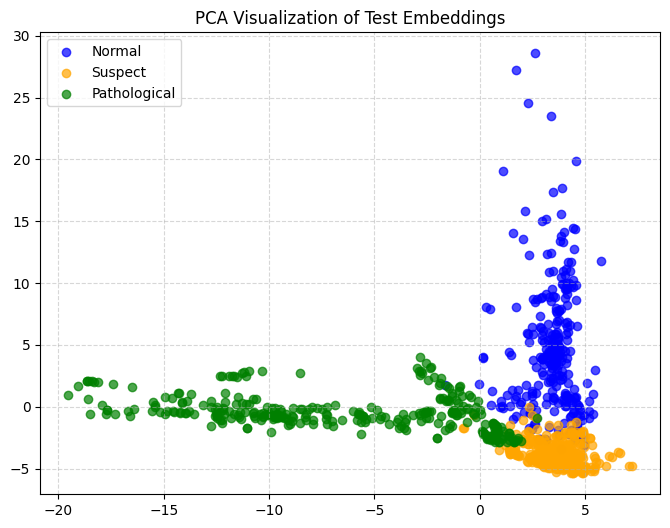

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Get the test embeddings
embedding_model = Model(inputs=model.input, outputs=model.layers[-2].output)
embeddings = embedding_model.predict(X_test_selected)

# Convert one-hot encoded labels back to class indices
y_test_labels = np.argmax(y_test, axis=1)
class_names = ['Normal', 'Suspect', 'Pathological']
colors = ['blue', 'orange', 'green']

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
for i in range(3):
    indices = y_test_labels == i
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1],
                label=class_names[i], alpha=0.7, c=colors[i])
plt.title("t-SNE Visualization of Test Embeddings")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# PCA visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
for i in range(3):
    indices = y_test_labels == i
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1],
                label=class_names[i], alpha=0.7, c=colors[i])
plt.title("PCA Visualization of Test Embeddings")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


Using last hidden layer: dense_4
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step 


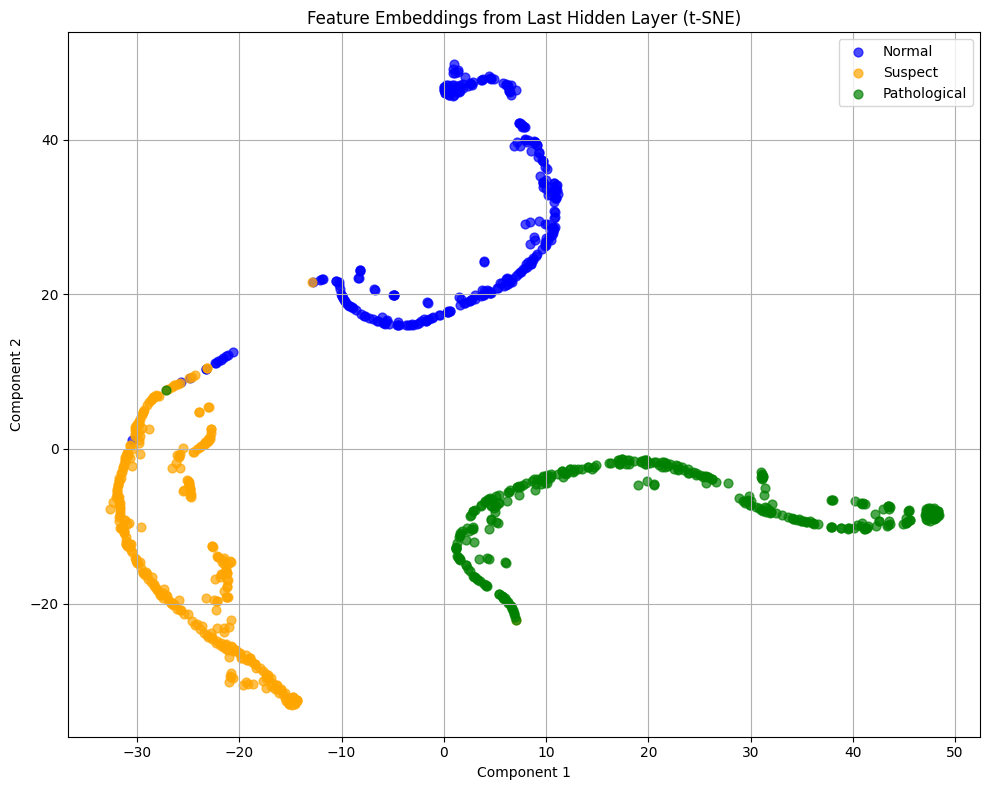

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow as tf

# 1. Create a model to extract last hidden layer output
layer_name = None
for layer in model.layers[::-1]:
    if 'dense' in layer.name or 'dropout' in layer.name:
        layer_name = layer.name
        break

print("Using last hidden layer:", layer_name)

# Create a new model that outputs activations from this layer
intermediate_layer_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output
)

# 2. Get embeddings for test set using correct selected features
embeddings = intermediate_layer_model.predict(X_test_selected)

# 3. Reduce to 2D
use_tsne = True  # Set to False to use PCA

if use_tsne:
    reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    title = 'Feature Embeddings from Last Hidden Layer (t-SNE)'
else:
    reducer = PCA(n_components=2)
    title = 'Feature Embeddings from Last Hidden Layer (PCA)'

embeddings_2d = reducer.fit_transform(embeddings)

# 4. Plot embeddings colored by true class
y_true_labels = np.argmax(y_test, axis=1)
class_names = ['Normal', 'Suspect', 'Pathological']
colors = ['blue', 'orange', 'green']

plt.figure(figsize=(10, 8))
for class_id, class_name in enumerate(class_names):
    idxs = y_true_labels == class_id
    plt.scatter(
        embeddings_2d[idxs, 0],
        embeddings_2d[idxs, 1],
        label=class_name,
        alpha=0.7,
        s=40,
        color=colors[class_id]
    )

plt.legend()
plt.title(title)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()


**Visualize Loss Surface Around Minimum**
This is more advanced and computationally intensive. The idea is to:

Take your final trained weights W*

Sample points around it in some directions

Evaluate the loss at those points to visualize how "flat" or "sharp" the minimum is


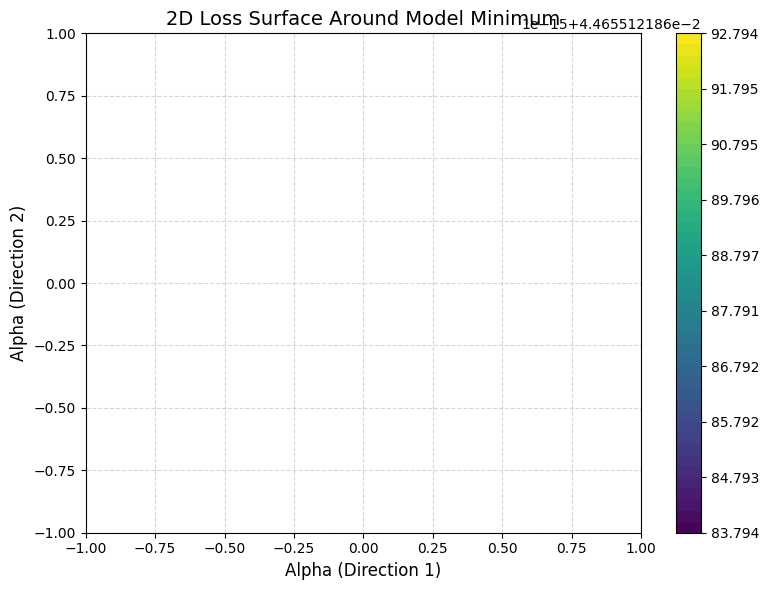

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

def loss_surface_2d(model, X, y, base_weights, direction1, direction2, alpha_range, num_points=10):
    losses = np.zeros((num_points, num_points))
    alphas = np.linspace(alpha_range[0], alpha_range[1], num_points)

    def set_weights_with_offset(base_weights, d1, d2, a1, a2):
        new_weights = []
        for w, dw1, dw2 in zip(base_weights, d1, d2):
            new_weights.append(w + a1 * dw1 + a2 * dw2)
        return new_weights

    for i, a1 in enumerate(alphas):
        for j, a2 in enumerate(alphas):
            new_weights = set_weights_with_offset(base_weights, direction1, direction2, a1, a2)
            model.set_weights(new_weights)
            loss = model.evaluate(X, y, verbose=0)[0]
            losses[i, j] = loss

    # Restore original weights
    model.set_weights(base_weights)
    
    return alphas, losses

# Use selected test data and one-hot labels
X_eval = X_test_selected
y_eval = y_test

# Get model's base weights and sample two random directions
base_weights = model.get_weights()
direction1 = [np.random.normal(size=w.shape) for w in base_weights]
direction2 = [np.random.normal(size=w.shape) for w in base_weights]

# Normalize directions
direction1 = [d / (np.linalg.norm(d) + 1e-8) for d in direction1]
direction2 = [d / (np.linalg.norm(d) + 1e-8) for d in direction2]

# Compute loss surface
alphas, loss_surface = loss_surface_2d(model, X_eval, y_eval, base_weights, direction1, direction2, alpha_range=[-1, 1])

# Plot the surface as a contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(alphas, alphas, loss_surface, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title('2D Loss Surface Around Model Minimum', fontsize=14)
plt.xlabel('Alpha (Direction 1)', fontsize=12)
plt.ylabel('Alpha (Direction 2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
